# Warmup

Warming things up, and ensuring that everything works as it is supposed to

In [15]:
# Note; if there's a bunch of red text below this; just run it again.
# Those are deprecation warnings, can be ignored, and won't show up the second time you run this cell.
using Interact
using PyPlot
using Colors
using Wavelets

Interact.Slider{Int64}([Reactive.Input{Int64}] 5,"frequency",5,1:10)

Interact.Slider{Float64}([Reactive.Input{Float64}] 3.1,"θ",3.1,0.0:0.1:6.2)

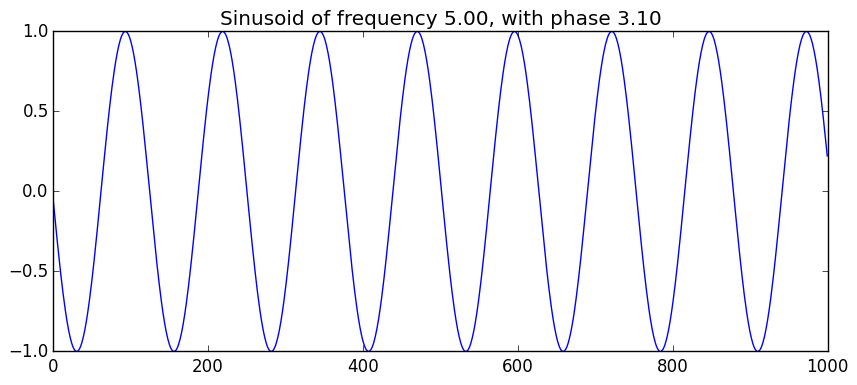

In [16]:
function sinusoid(freq, θ)
    t = linspace(0, 10, 1000)
    return sin(freq*t - θ)
end

fig = figure(figsize=(10, 4))
@manipulate for frequency in 1:10, θ in 0:.1:2π
    withfig(fig) do
        signal = sinusoid(frequency,θ)
        plot(signal)
        title(@sprintf("Sinusoid of frequency %.2f, with phase %.2f", frequency, θ))
    end
end

Interact.Slider{Int64}([Reactive.Input{Int64}] 64,"delay",64,0:8:128)

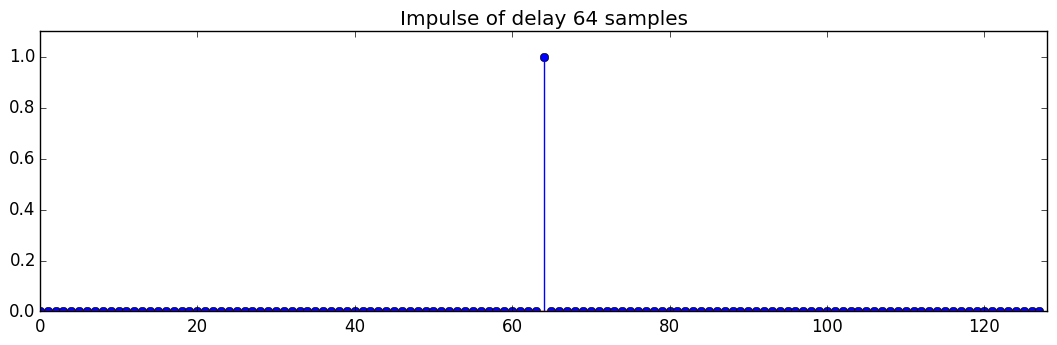

In [18]:
function make_impulse(delay)
    impulse = zeros(128)
    impulse[delay+1] = 1.0
    return impulse
end

impulse = nothing
@manipulate for delay in 0:8:128
    fig = figure(figsize=(13, 3.5))
    withfig(fig) do
        global impulse
        impulse = make_impulse(delay)
        stem(impulse)
        ylim([0, 1.1])
        xlim([0, 128])
        title("Impulse of delay $delay samples")
    end
end

# So what is a Wavelet?

Well, as it turns out, the Daubechies 4th order wavelet is really just four numbers:

$$
h_\text{db4} = \left [ \frac{1 - \sqrt{3}}{8}, \frac{-3 + \sqrt{3}}{8}, \frac{3 + \sqrt{3}}{8}, \frac{-1 - \sqrt{3}}{8} \right ]
$$

In [4]:
# Return the Daubechies-4 wavelet filter
function db4()
    return [ 1 - sqrt(3),
            -3 + sqrt(3),
             3 + sqrt(3),
            -1 - sqrt(3)]/8.0
end

h_db4 = db4()

4-element Array{Float64,1}:
 -0.0915064
 -0.158494 
  0.591506 
 -0.341506 

These four numbers represent a filter, known as the "Wavelet Filter".  We use this to, well, filter an incoming sequence.  Let's look at the time domain and frequency domain of this filter:

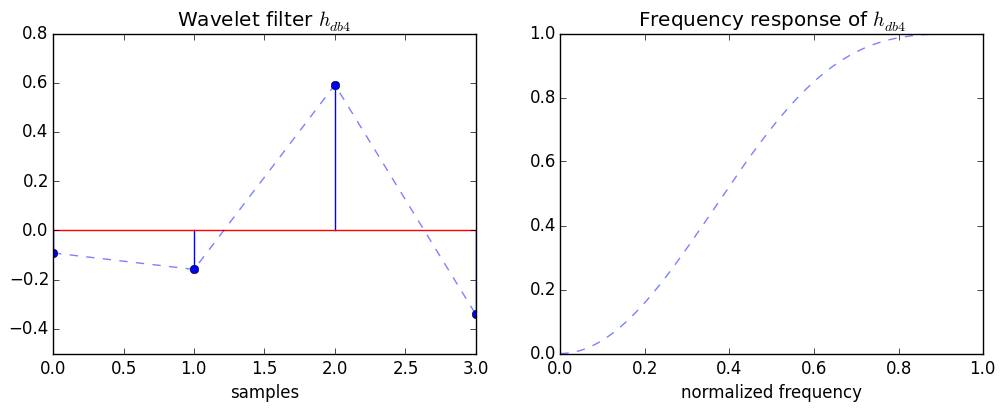

In [5]:
figure(figsize=(12,4))
subplot(1,2,1)
stem(h_db4)
plot(h_db4, "b--", alpha=.5)
ylim(-.5, .8)
xlabel("samples")
title("Wavelet filter \$h_{db4}\$")

subplot(1,2,2)
h_db4_pad = [h_db4; zeros(1024 - length(h_db4))]
plot( linspace(0, 1, 512), abs(fft(h_db4_pad)[1:512]), "b--", alpha=.5)
xlabel("normalized frequency")
title("Frequency response of \$h_{db4}\$");

# It's..... a highpass filter?

So what does this mean?  Looking at that frequency response we see that it is some kind of high pass filter.  In point of fact, it's a highpass filter that looks like it just about carves the spectrum in half.

Every wavelet has a dual filter, known as the "scaling filter".  I bet you can't guess what it looks like:

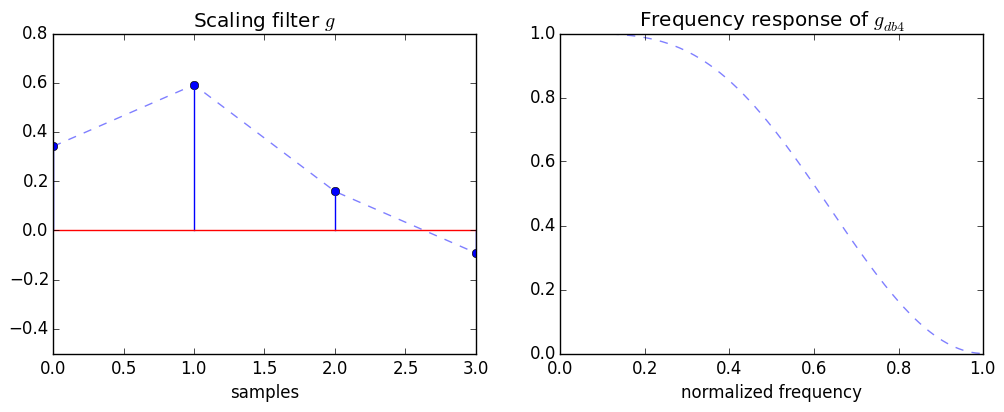

In [6]:
# Given a wavelet filter, generate its scaling filter (e.g. given "h", return "g")
function scaling_filter(h)
    # g is a time-reversed copy of h
    g = h[end:-1:1]

    # that also has every other sample flipped
    for idx in 1:2:length(g)
        g[idx] = -g[idx]
    end
    
    # spit it back at the user like the child we are
    return g
end

# Let's create a g_db4 off of our h_db4
g_db4 = scaling_filter(h_db4)

figure(figsize=(12,4))
subplot(1,2,1)
stem(g_db4)
plot(g_db4, "b--", alpha=.5)
ylim(-.5, .8)
xlabel("samples")
title("Scaling filter \$g\$");

subplot(1,2,2)
g_db4_pad = [g_db4; zeros(1024 - length(g_db4))]
plot( linspace(0, 1, 512), abs(fft(g_db4_pad)[1:512]), "b--", alpha=.5)
xlabel("normalized frequency")
title("Frequency response of \$g_{db4}\$");

# So.... it's a lowpass filter?

Yep!  And the way that we generate our "scaling filter" (the lowpass one) from the "wavelet filter" (the highpass one) is a little bizarre.  That being said, these two filters (of which the Daubechies 4 wavelet is only a single instance) are the two building blocks of any wavelet transform.  From these two filters, we will create a whole filterbank, by combining the two of them again and again to carve up the spectrum into smaller and smaller chunks:

Interact.Options{:ToggleButtons,Int64}([Reactive.Input{Int64}] 2,"num_levels",2,"2",Interact.OptionDict(Any["2","3","4","5","6","7","8"],Dict{Any,Any}("8"=>8,"4"=>4,"5"=>5,"2"=>2,"6"=>6,"7"=>7,"3"=>3)),Any[],Any[])

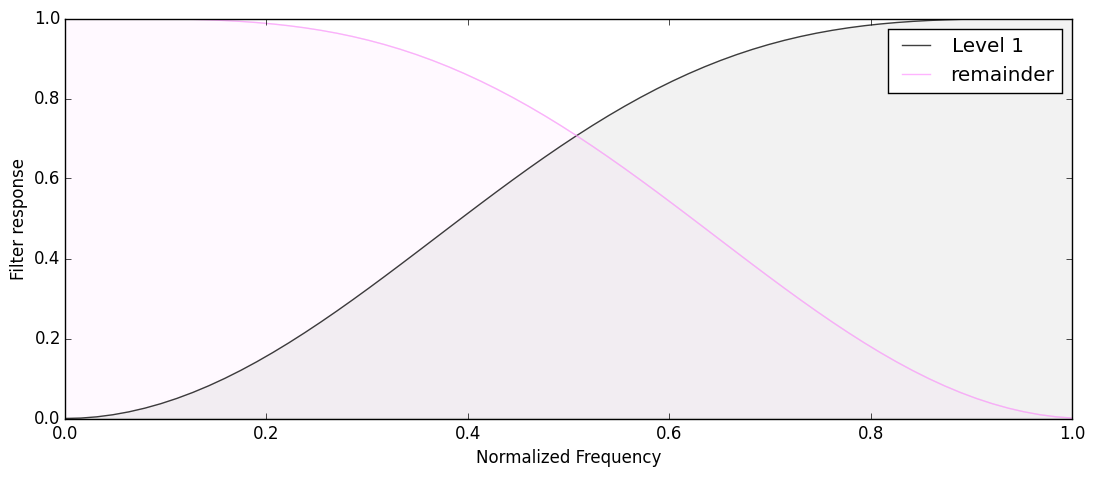

In [19]:
# Performs the pyramidal stationary wavelet transform of a sequence x, which must have
# length equal to a power of 2. Uses the wavelet filter h and scaling filter g given by the user.
function swt(x, h, g, J = length(x) - 1)
    # Get the length of x and the length of h/g:
    N = length(x)
    L = length(h)
    
    # Define our variables, and load x into V_j, which will immediately be loaded into V_{j-1} aka V_prev
    W = zeros(J,N)
    V_j = x
    
    # Perform an iteration for each scale j:
    # (we skip the first scale as we already "did it" by setting V_j to x)
    for j in 2:J
        # Save last iteration's V to use later
        V_prev = V_j
        
        # Create V_j, and fill it in the next loop
        V_j = zeros(N)
        
        # Iterate over time indices, performing dot products with previous output:
        for t in 0:(N-1)
            # Initialize τ (our inner convolution time variable) to t
            τ = mod((t + div(L,4)*2^(j - 2)),N)
            
            # Inner loop to do the shifting, dotproducts between and movement between
            # the filters and V_prev to fill out W_j[t] and V_j[t]
            for n in 1:L
                W[j-1,t+1] += h[n]*V_prev[τ+1]
                V_j[t+1] += g[n]*V_prev[τ+1]
                τ = mod(τ - 2^(j - 2),N)
            end
        end
    end

    # Finally, append in the last scaling coeffs, and return
    W[J,:] = circshift(V_j, 2^(J-1))
    return W
end

W = nothing
fig = figure(figsize=(13,5))
@manipulate for num_levels in collect(2:8)
    withfig(fig) do
        global W
        num_samples = convert(Int,length(impulse))
        
        # Run our impulse through the proverbial ringer!
        W = swt(impulse, h_db4, g_db4, num_levels)

        # Generate some distinguishable colors
        dcolors = distinguishable_colors(num_levels)

        # Plot each level
        for level in 1:num_levels
            # Frequency values on the x-axis
            x = linspace(0, 1, div(num_samples,2))

            # Filter responses on the y-axis
            y = abs(fft(W[level,:]'))[1:div(num_samples,2)]

            # Zeros to fill between zero and y
            z = zeros(div(num_samples,2))

            fillcolor = hex(dcolors[level])
            plot(x, y, "#$fillcolor", alpha=0.75)
            fill_between( x, y, z, facecolor="#$fillcolor", alpha=0.05)
        end

        # Write out legend
        legend_texts = ["Level $idx" for idx in 1:num_levels-1]
        push!(legend_texts, "remainder")
        legend(legend_texts)
        xlabel("Normalized Frequency")
        ylabel("Filter response")
    end
end


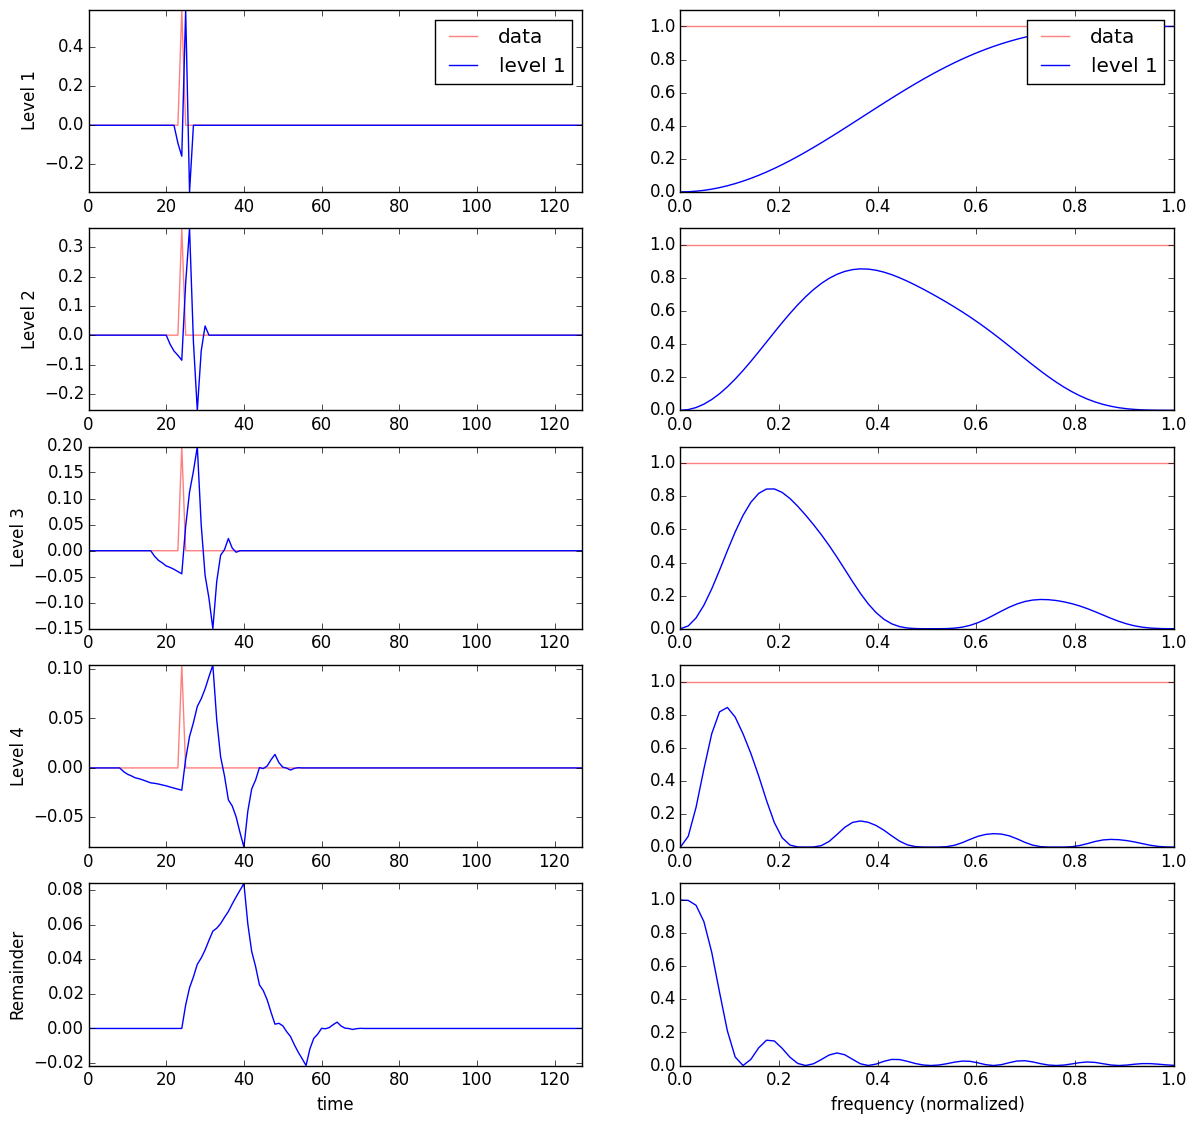

In [20]:
function plot_stationary_wavelet_levels(x, W)
    num_levels = size(W,1) - 1
    num_samples = size(W,2)
    
    for idx = 1:num_levels
        subplot(num_levels+1, 2, 2*idx - 1)
        w = W[idx,:][:]
        plot( x.*maximum(w)./maximum(x), "r", alpha=0.5)
        plot( w )
        axis("tight")
        if idx == 1
            legend(["data", "level $idx"])
        end
        ylabel("Level $idx")
        
        subplot(num_levels+1, 2, 2*idx)
        plot( linspace(0,1,num_samples/2), abs(fft(x))[1:div(num_samples,2)], "r", alpha=0.5 )
        plot( linspace(0,1,num_samples/2), abs(fft(w))[1:div(num_samples,2)] )
        axis("tight")
        if idx == 1
            legend(["data", "level $idx"])
        end
        ylim([0, 1.1])
    end
    
    subplot(num_levels+1, 2, 2*num_levels + 1)
    w = W[num_levels+1,:][:]
    plot( w )
    axis("tight")
    ylabel("Remainder")
    xlabel("time")
    
    subplot(num_levels+1, 2, 2*num_levels + 2)
    plot( linspace(0,1,num_samples/2), abs(fft(w))[1:div(num_samples,2)] )
    axis("tight")
    ylim([0, 1.1])
    xlabel("frequency (normalized)")
    return nothing
end

# If you're thinking "lolwat" here, this scaling just seemed to
# work best at the time, to ensure a consistent height for the giant graphs below
figure(figsize=(14,5*(size(W,1) - 1).^.7))

plot_stationary_wavelet_levels(impulse, W)

# Elliot, I am completely lost

Those graphs are pretty, but why are there shark fins running around in my squiggly lines?!

The key takeaway is this; all we've done is define a fancy method of splitting up the frequencies in our signal, the different frequency bands are of different sizes, (they get wider as frequency gets higher) and are numbered in _descending_ order, e.g. Level 1 is the highest frequency band.  So without further ado, let's analyze some data to get a feel for what this is actually doing!

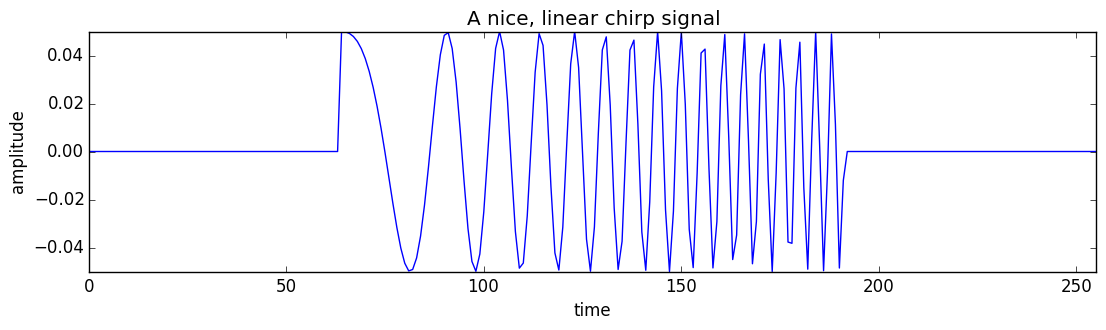

In [21]:
function make_chirp(t, f0, f1)
    beta = (f1 - f0) / t[end]
    phase = f0 * t + 0.5 * beta * t.^2
    return .05*cos(phase)
end

figure(figsize=(13,3))
t = linspace(0, 1, 128)
chirp = [zeros(64); make_chirp(t, 10, 200); zeros(64)]
plot(chirp)
title("A nice, linear chirp signal")
xlabel("time")
ylabel("amplitude")
axis("tight");

Interact.Options{:ToggleButtons,Int64}([Reactive.Input{Int64}] 2,"num_levels",2,"2",Interact.OptionDict(Any["2","3","4","5","6","7","8"],Dict{Any,Any}("8"=>8,"4"=>4,"5"=>5,"2"=>2,"6"=>6,"7"=>7,"3"=>3)),Any[],Any[])

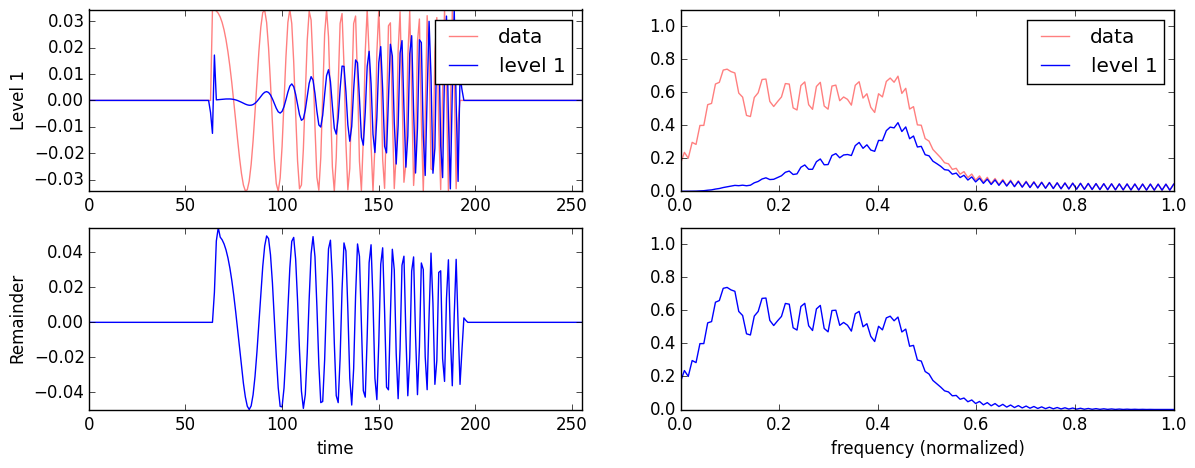

In [10]:
@manipulate for num_levels in collect(2:8)
    fig = figure(figsize=(14,5*(num_levels - 1).^.7))
    withfig(fig) do
        # Run our impulse through the proverbial ringer!
        W = swt(chirp, h_db4, g_db4, num_levels)

        plot_stationary_wavelet_levels(chirp, W)
    end
end

Now, if this all seems too simple, that's because it is. What we have described here is not the discrete wavelet transform, it's the **stationary** wavelet transform.  The discrete wavelet transform has one more step, which is downsampling.

All levels higher than level one have successively lower and lower frequency content.  It's kind of a shame to capture signals with such small bandwidths with our (comparatively) high samplerate; very wasteful of data.  So, during each step (including level 1!) we downsample by a factor of two.

Interact.Options{:ToggleButtons,Int64}([Reactive.Input{Int64}] 2,"num_levels",2,"2",Interact.OptionDict(Any["2","3","4","5","6","7","8"],Dict{Any,Any}("8"=>8,"4"=>4,"5"=>5,"2"=>2,"6"=>6,"7"=>7,"3"=>3)),Any[],Any[])

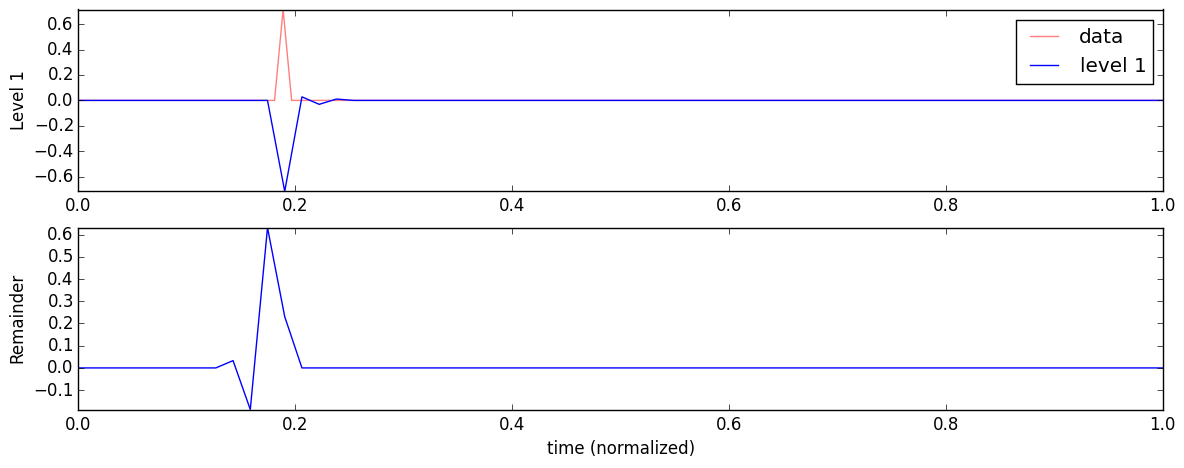

In [22]:
# This time, rather than using our own wavelet transform function, we'll use the Wavelets package:
using Wavelets

function plot_wavelet_levels(x, Z, num_levels)
    num_samples = length(Z)
    
    for idx = 1:num_levels
        subplot(num_levels+1, 1, idx)
        w = Z[div(num_samples,2^(idx))+1:div(num_samples,2^(idx-1))]
        plot( linspace(0,1,length(x)), x.*maximum(abs(w))/maximum(x), "r", alpha=0.5)
        plot( linspace(0,1,length(w)), w )
        axis("tight")
        if idx == 1
            legend(["data", "level $idx"])
        end
        ylabel("Level $idx")
    end
    
    subplot(num_levels+1, 1, num_levels + 1)
    w = w = Z[1:div(num_samples,2^(num_levels))]
    plot( linspace(0,1,length(w)), w )
    axis("tight")
    ylabel("Remainder")
    xlabel("time (normalized)")
    return nothing
end

@manipulate for num_levels in collect(2:8)
    fig = figure(figsize=(14,5*(num_levels - 1).^.7))

    withfig(fig) do
        # This is a proper dwt (Discrete Wavelet Transform), not the swt (Stationary Wavelet Transform) from before
        Z = dwt(impulse, wavelet(WT.db4), num_levels - 1)
        
        plot_wavelet_levels(impulse, Z, num_levels-1)
    end
end


# Make sure the above graphs are for a delay > 16

Anything else just looks really confusing.  Also, let's do the same as above, but for the chirp signal instead:

Interact.Options{:ToggleButtons,Int64}([Reactive.Input{Int64}] 2,"num_levels",2,"2",Interact.OptionDict(Any["2","3","4","5","6","7","8"],Dict{Any,Any}("8"=>8,"4"=>4,"5"=>5,"2"=>2,"6"=>6,"7"=>7,"3"=>3)),Any[],Any[])

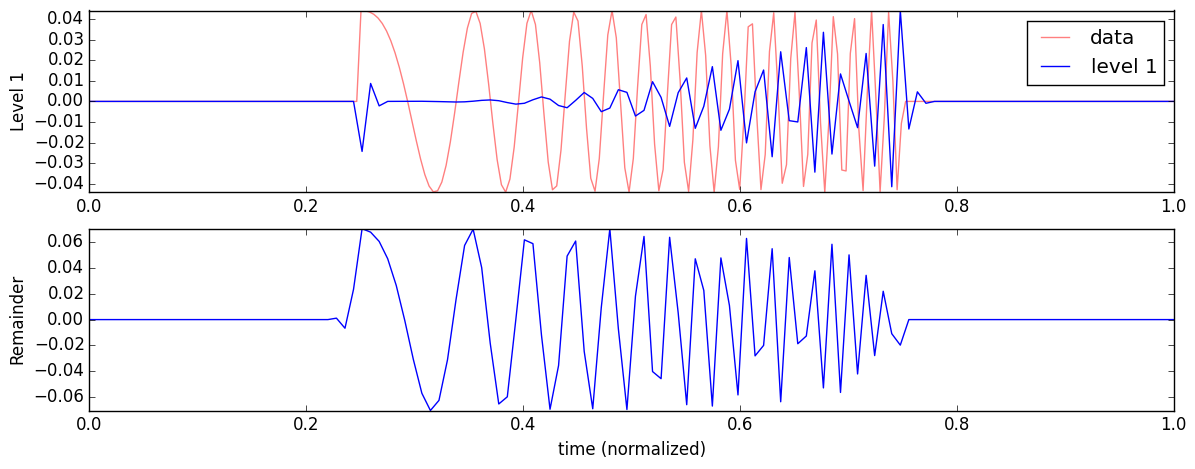

In [23]:
@manipulate for num_levels in collect(2:8)
    chirp_dwt_fig = figure(figsize=(14,5*(num_levels - 1).^.7))
    withfig(chirp_dwt_fig) do
        # This is a proper dwt (Discrete Wavelet Transform), not the swt (Stationary Wavelet Transform) from before
        Z = dwt(chirp, wavelet(WT.db4), num_levels - 1)
        
        plot_wavelet_levels(chirp, Z, num_levels-1)
    end
end

The time decimation naturally emphasizes the time-resolution of high frequency signals, while preserving the frequency accuracy of low-frequency signals.  It also has the really interesting property of taking in exactly N numbers, and then giving out exactly N numbers.  In fact, most DWT implementations will not give you back a 2d array, they will give you back a 1d array of the same size you passed in, but with the different levels packed in like so:

Interact.Options{:ToggleButtons,Int64}([Reactive.Input{Int64}] 2,"num_levels",2,"2",Interact.OptionDict(Any["2","3","4","5","6","7","8"],Dict{Any,Any}("8"=>8,"4"=>4,"5"=>5,"2"=>2,"6"=>6,"7"=>7,"3"=>3)),Any[],Any[])

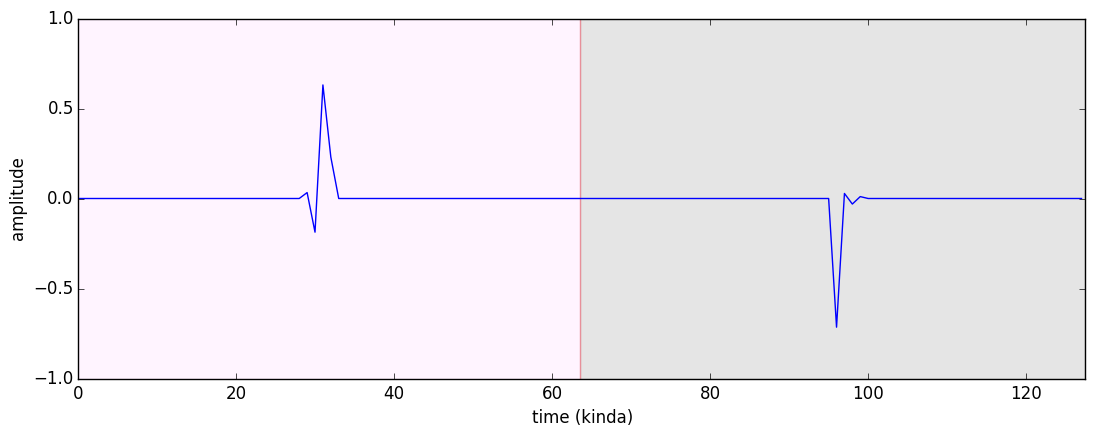

In [13]:
@manipulate for num_levels in collect(2:8)
    fig = figure(figsize=(13,4.5))

    # Generate some distinguishable colors
    dcolors = distinguishable_colors(num_levels)
    
    withfig(fig) do
        # This is a proper dwt (Discrete Wavelet Transform), not the swt (Stationary Wavelet Transform) from before
        Z = dwt(impulse, wavelet(WT.db4), num_levels - 1)

        num_samples = length(Z)
        for idx in 1:num_levels-1
            xl = [num_samples/(2^idx), num_samples/(2^(idx-1))] - 0.5
            plot([xl[1], xl[1]], [-1, 1], "r", alpha=0.3)
            fillcolor = hex(dcolors[idx])
            fill_between(xl, [-1, -1], [1, 1], color="#$fillcolor", alpha=0.1)
        end
        idx = num_levels
        fillcolor = hex(dcolors[idx])
        fill_between([0, num_samples/(2^(idx-1)) - 0.5], [-1, -1], [1, 1], color="#$fillcolor", alpha=0.1)
        plot(Z)
        axis("tight")
        xlabel("time (kinda)")
        ylabel("amplitude")
    end
end


128

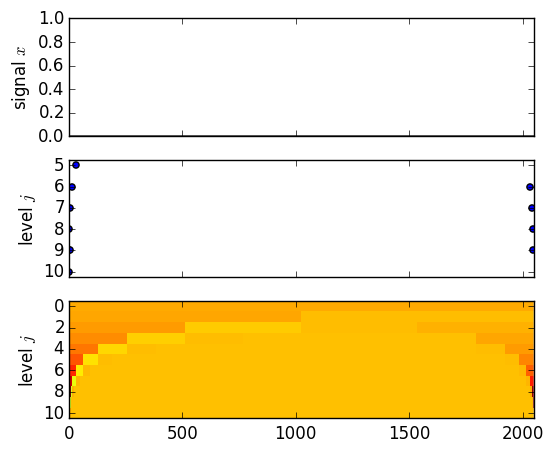

In [14]:

using Wavelets
using PyPlot

J = 11
n = 2^J
x = [1; zeros(2047)] #testfunction(n,"Bumps")
display(length(impulse))
y = dwt(x, wavelet(WT.db4))
d,l = wplotdots(y, 0.1, n)
A = wplotim(y)

f, ax = subplots(3, 1, sharex=true)
ax[1][:plot](x, "k")
ax[1][:set_xlim]([0,n])
ax[1][:set_ylabel](L"signal $x$")
ax[2][:scatter](d,l)
ax[2][:margins](0.05)
ax[2][:set_ylim](ax[2][:get_ylim]()[2:-1:1])
ax[2][:set_ylabel](L"level $j$")
ax[3][:imshow](A,aspect="auto",interpolation="none")
ax[3][:set_ylim]([J-0.5,-0.5])
ax[3][:set_ylabel](L"level $j$")

f[:set_size_inches](6,5)

savefig("transform1d_bumps.png")

